# Questão 3 - Clusterização

## Sumário
- [Preliminares](#Preliminares)
- [Tratando atributos não numéricos](#Tratando-atributos-não-numéricos)
- [Agrupamento sem normalização](#Agrupamento-sem-normalização)
- [Normalização dos dados e re-execução](#Normalização-dos-dados-e-re-execução)
- [Visualização dos Clusters](#Visualização-dos-Clusters)
- [Análise utilizando outras métricas](#Análise-utilizando-outras-métricas)
- [Conclusão](#Conclusão)

## Preliminares
Importação de dependências, carregamento da base de dados, remoção de duplicatas e observação inicial dos dados.

In [1]:
from scipy import stats

import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn import decomposition
from sklearn import manifold
from sklearn import cluster
from sklearn import model_selection
from sklearn import metrics

In [2]:
sns.set(rc = {'figure.figsize':(16, 8)})

df = pd.read_csv('Live.csv', delimiter = ',') # Abrir base de dados

df.head()

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4
0,246675545449582_1649696485147474,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,NaN,NaN,NaN,NaN
1,246675545449582_1649426988507757,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,NaN,NaN,NaN,NaN
2,246675545449582_1648730588577397,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,NaN,NaN,NaN,NaN
3,246675545449582_1648576705259452,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0,NaN,NaN,NaN,NaN
4,246675545449582_1645700502213739,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0,NaN,NaN,NaN,NaN


Uma análise inicial indica que as colunas 'Column1', 'Column2', 'Column3' e 'Column4' não contém alguma informação. 

Agora, eliminemos as duplicatas (caso existam), e vejamos o tipo de dado de cada coluna: 

In [3]:
print("Duplicatas: %d" % (len(df[df.duplicated()])))
df.drop_duplicates(keep = 'first', inplace = True) #remover duplicatas

df.reset_index(inplace = True) # por algum motivo eliminar linhas resulta em um index mucho louco
df.drop(columns = ['index'], inplace = True)

Duplicatas: 51


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6999 entries, 0 to 6998
Data columns (total 16 columns):
status_id           6999 non-null object
status_type         6999 non-null object
status_published    6999 non-null object
num_reactions       6999 non-null int64
num_comments        6999 non-null int64
num_shares          6999 non-null int64
num_likes           6999 non-null int64
num_loves           6999 non-null int64
num_wows            6999 non-null int64
num_hahas           6999 non-null int64
num_sads            6999 non-null int64
num_angrys          6999 non-null int64
Column1             0 non-null float64
Column2             0 non-null float64
Column3             0 non-null float64
Column4             0 non-null float64
dtypes: float64(4), int64(9), object(3)
memory usage: 875.0+ KB


Na base de dados, 51 valores duplicados foram eliminados.

Ainda, nota-se que as colunas nomeadas Column1 a Column4 não contém nenhum valor, para se ter certeza desta observação, verifica-se a quantia de dados faltantes em cada coluna:

In [5]:
df.isnull().sum()

status_id              0
status_type            0
status_published       0
num_reactions          0
num_comments           0
num_shares             0
num_likes              0
num_loves              0
num_wows               0
num_hahas              0
num_sads               0
num_angrys             0
Column1             6999
Column2             6999
Column3             6999
Column4             6999
dtype: int64

De fato estas 4 colunas não contém nenhuma informação, e portanto serão descartadas:

In [6]:
df.drop(columns = ['Column1', 'Column2', 'Column3', 'Column4'], inplace = True)

Após eliminar estas quatro colunas não restam atributos faltando, contudo ainda é necessário analisar melhor os atributos que não estão em formato numérico: 'status_id', 'status_type' e 'status_published', uma vez que é necessária fazer a conversão destes para poder serem usados pelo algoritmo de aprendizagem de máquina.

- [Voltar ao topo](#Sumário)

## Tratando atributos não numéricos

In [7]:
unique = df['status_id'].unique()
print("Valores únicos de status_id:", unique, "\nTamanho:", len(unique), "\n")
unique = df['status_type'].unique()
print("Valores únicos de status_type:", unique, "\nTamanho:", len(unique), "\n")
unique = df['status_published'].unique()
print("Valores únicos de status_published:", unique, "\nTamanho:", len(unique))

Valores únicos de status_id: ['246675545449582_1649696485147474' '246675545449582_1649426988507757'
 '246675545449582_1648730588577397' ...
 '1050855161656896_1060126464063099' '1050855161656896_1058663487542730'
 '1050855161656896_1050858841656528'] 
Tamanho: 6997 

Valores únicos de status_type: ['video' 'photo' 'link' 'status'] 
Tamanho: 4 

Valores únicos de status_published: ['4/22/2018 6:00' '4/21/2018 22:45' '4/21/2018 6:17' ... '9/21/2016 23:03'
 '9/20/2016 0:43' '9/10/2016 10:30'] 
Tamanho: 6913


O atributo status_type é o que possui a menor cardinalidade entre os atributos não numéricos, podendo assumir 4 valores diferentes.

Enquanto o atributo status_published, apesar de ter vários valores distintos, aparenta se tratar da data e hora no qual uma publicação foi realizada, esta informação poderia ser dividida em mais atributos.

Por fim, o status_id possui uma alta cardinalidade, pelo ver, este atributo parece conter um código identificador para cada publicação, contudo, não é possível garantir isso ainda, pois existem pelo menos um valor distinto deste atributo que ocorre mais de uma vez nesta base de dados.

### status_type
Este atributo é do tipo categórico e deve ser convertido para númerico usando one-hot encoding:

In [8]:
oh = pd.get_dummies(df['status_type'])

df = df.drop(columns = ['status_type'])

df = df.join(oh)

df.head()

,status_id,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,link,photo,status,video
0,246675545449582_1649696485147474,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,0,0,0,1
1,246675545449582_1649426988507757,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,0,1,0,0
2,246675545449582_1648730588577397,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,0,0,0,1
3,246675545449582_1648576705259452,4/21/2018 2:29,111,0,0,111,0,0,0,0,0,0,1,0,0
4,246675545449582_1645700502213739,4/18/2018 3:22,213,0,0,204,9,0,0,0,0,0,1,0,0


### status_published
Este atributo contém informações sobre a data e hora de uma publicação, então pode ser dividida em outros atributos, no caso serão criados os atributos 'day', 'month', 'year' e 'time' a partir do atributo original, sendo que 'time' será medido em minutos, com o propósito de combinar as horas com os minutos em uma coluna apenas.

In [9]:
dt = df['status_published'].to_list()
hours = []
minutes = []
years = []
months = []
days = []
#formato: 4/22/2018 6:00
for d in dt:
    split = d.split(" ")
    split2 = split[0].split("/")
    
    months.append(int(split2[0]))
    days.append(int(split2[1]))
    years.append(int(split2[2]))
    
    split2 = split[1].split(':')
    hours.append(int(split2[0]))
    minutes.append(int(split2[1]))
    
dt_df = pd.DataFrame({"day": days, "month": months, "year": years, "hour": hours, "minute": minutes})

df = df.join(dt_df)
df.drop(columns = ['status_published'], inplace = True)

df.head()

,status_id,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,link,photo,status,video,day,month,year,hour,minute
0,246675545449582_1649696485147474,529,512,262,432,92,3,1,1,0,0,0,0,1,22,4,2018,6,0
1,246675545449582_1649426988507757,150,0,0,150,0,0,0,0,0,0,1,0,0,21,4,2018,22,45
2,246675545449582_1648730588577397,227,236,57,204,21,1,1,0,0,0,0,0,1,21,4,2018,6,17
3,246675545449582_1648576705259452,111,0,0,111,0,0,0,0,0,0,1,0,0,21,4,2018,2,29
4,246675545449582_1645700502213739,213,0,0,204,9,0,0,0,0,0,1,0,0,18,4,2018,3,22


### status_id
Este atributo não me aparenta ter alguma utilidade original, imagino que se trata do valor identificador para uma publicação, contudo, darei uma segunda chance para este mostrar seu valor.

Como os valores deste atributo estão separados por um '_', vejamos como a parte direita deste atributo se relaciona a parte esquerda:

In [10]:
dt = df['status_id'].to_list()
left = []
right = []

for d in dt:
    split = d.split("_")
    left.append(split[0])
    right.append(split[1])

lr_df = pd.DataFrame({"left_status_id": left, "right_status_id": right})

df = df.join(lr_df)
df.drop(columns = ['status_id'], inplace = True)

print("Quantidade de valores únicos para left_status_id:" ,len(df['left_status_id'].unique()))

Quantidade de valores únicos para left_status_id: 9


O número de valores únicos para a parte esquerda é bastante baixo, contudo, não é possível fazer alguma conclusão sobre isso pelo fato de que talvez os valores atribuídos para a coluna 'status_id' original não sigam alguma ordem lógica (e.g. tenham sido gerados por alguma função de dispersão). 

Para tentar adquirir mais informações, com o propósito de facilitar a decisão a ser tomada em relação a este atributo, vejamos como os dois novos atributos se relacionam:

In [11]:
unique = df['right_status_id'].unique()
print("Valores únicos de right_status_id: ", len(unique))

for unique_right in unique:
    loc = df.loc[df['right_status_id'] == unique_right]
    matches = loc['left_status_id'].unique()
    if(len(matches) > 1): 
        print("left_status_id para", unique_right, ":", matches, "\nQuantidade: ", len(matches))

Valores únicos de right_status_id:  6997


Pela porção de código acima, o número de valores distintos de 'right_status_id' é igual ao número de valores distintos do atributo original 'status_id', e portanto, não foi encontrado um valor de 'right_status_id' que se relacione com mais de um valor de 'left_status_id'. O que leva a crer que este atributo se trata de um valor que permita identificar uma publicação na base de dados (i.e. criado por uma função de dispersão).

Com estas informações, a decisão tomada para este atributo é de simplesmente removê-lo da base de dados, pois não parece ter alguma informação relevante associada a ele.

In [12]:
df.drop(columns = ['left_status_id', 'right_status_id'], inplace = True)

- [Voltar ao topo](#Sumário)

## Agrupamento sem normalização
Nesta seção, são executados os algoritmos de agrupamento K-means e Hierárquico sem realizar uma normalização dos dados.

O algoritmo kmeans será executado utilizando tanto a inicialização aleatória dos centróides como a inicialização padrão utilizada pelo scikit. Enquanto que o Hierárquico será executado usando a ligação individual e também o completo. 

Para todos os casos, serão executados os algoritmos usando um número de clusters dado pela função i^2 onde i varia de 2 até 9. 

A métrica utilizada para avaliar a qualidade dos clusters obtidos será a média do coeficiente 'Silhueta' de todos os objetos, os valores destes coeficientes variam entre -1 e 1, onde um valor -1 indica que os objetos foram agrupados incorretamente, 0 indica que os clusters estão sobrepostos e 1 indica clusters densos e bem separados.

In [13]:
results = []
labels_kr = []
labels_kdi = []
labels_hs = []
labels_hc = []

iterations = [i**2 for i in range (2, 10)]

for i in iterations:
    hierarchical_single = cluster.AgglomerativeClustering(n_clusters = i, linkage = "single")
    hierarchical_complete = cluster.AgglomerativeClustering(n_clusters = i, linkage = "complete")
    
    kmeans_random = cluster.KMeans(n_clusters = i, init = "random").fit(df)
    kmeans_default_init = cluster.KMeans(n_clusters = i).fit(df) #default init = k-means++

    hierarchical_single_clustered =  df.assign(cluster_number = hierarchical_single.fit_predict(df))
    hierarchical_complete_clustered =  df.assign(cluster_number = hierarchical_complete.fit_predict(df))
    
    kmeans_random_clustered = df.assign(cluster_number = kmeans_random.predict(df))
    kmeans_default_init_clustered = df.assign(cluster_number = kmeans_default_init.predict(df))
    
    labels_kr.append(kmeans_random_clustered)
    labels_kdi.append(kmeans_default_init_clustered)
    labels_hs.append(hierarchical_single_clustered)
    labels_hc.append(hierarchical_complete_clustered)
    
    results.append({"Number of clusters": i, 
                    "Hierarchical Single": 
                    metrics.silhouette_score(hierarchical_single_clustered, labels = hierarchical_single_clustered['cluster_number']),
                    "Hierarchical Complete":
                    metrics.silhouette_score(hierarchical_complete_clustered, labels = hierarchical_complete_clustered['cluster_number']),
                    "K-Means Random Init":
                    metrics.silhouette_score(kmeans_random_clustered, labels = kmeans_random_clustered['cluster_number']),
                    "K-Means Default Init":
                    metrics.silhouette_score(kmeans_default_init_clustered, labels = kmeans_default_init_clustered['cluster_number'])})

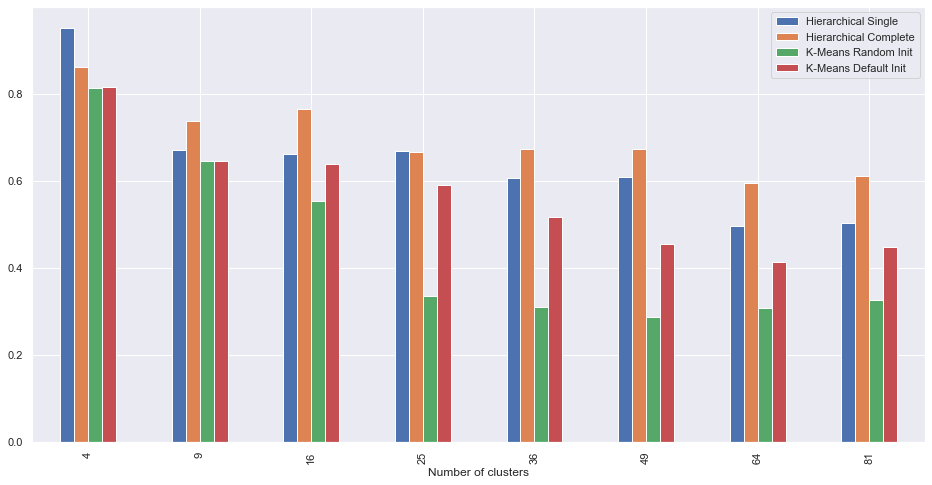

In [14]:
pd.DataFrame(results).plot.bar(x = "Number of clusters",
                                y = ["Hierarchical Single", "Hierarchical Complete", "K-Means Random Init", "K-Means Default Init"])

O gráfico de barras acima mostra que conforme o número de clusters aumenta, o desempenho dos algoritmos em relação a métrica silhueta cai, sendo que os resultados melhores para esta métrica foram para 4 clusters. O que se imagina, é que a base de dados utilizada não possui uma separação clara e densa conforme um número maior de clusters é utilizado.

Ainda, o que se percebe é que o algoritmo hierárquico apresentou resultados melhores do que o K-Means, sendo a diferença na métrica maior conforme o número de clusters aumenta, sendo o hierárquico com ligação completa aquele que obteve resultados melhores em 6 das 8 execuções nesta métrica, porém o melhor resultado de todos foi com hierárquico simples utilizando 4 clusters.

Quanto ao K-Means, o que se percebe é que utilizar a inicialização aleatória acabou por degradar o desempenho deste algoritmo se comparado ao K-Means com a inicialização padrão.

- [Voltar ao topo](#Sumário)

## Normalização dos dados e re-execução

Normalizar os dados para re-executar os algoritmos, a normalização utilizada será o escalonamento robusto.

In [15]:
scaler = preprocessing.RobustScaler()

scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.columns.values)

scaled.head()

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,link,photo,status,video,day,month,year,hour,minute
0,2.366834,23.090909,65.50,2.272727,30.666667,3.0,1.0,1.0,0.0,0.0,-1.0,0.0,1.0,0.400000,-0.285714,0.5,-0.142857,-0.838710
1,0.462312,-0.181818,0.00,0.563636,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,-0.285714,0.5,2.142857,0.612903
2,0.849246,10.545455,14.25,0.890909,7.000000,1.0,1.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.333333,-0.285714,0.5,-0.142857,-0.290323
3,0.266332,-0.181818,0.00,0.327273,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,-0.285714,0.5,-0.714286,0.096774
4,0.778894,-0.181818,0.00,0.890909,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.133333,-0.285714,0.5,-0.571429,-0.129032


In [16]:
results_scaled = []
labels_kr_scaled = []
labels_kdi_scaled = []
labels_hs_scaled = []
labels_hc_scaled = []

for i in iterations:
    hierarchical_single = cluster.AgglomerativeClustering(n_clusters = i, linkage = "single")
    hierarchical_complete = cluster.AgglomerativeClustering(n_clusters = i, linkage = "complete")
    
    kmeans_random = cluster.KMeans(n_clusters = i, init = "random").fit(scaled)
    kmeans_default_init = cluster.KMeans(n_clusters = i).fit(scaled) #default init = k-means++
    
    hierarchical_single_clustered =  scaled.assign(cluster_number = hierarchical_single.fit_predict(scaled))
    hierarchical_complete_clustered =  scaled.assign(cluster_number = hierarchical_complete.fit_predict(scaled))
    
    kmeans_random_clustered = scaled.assign(cluster_number = kmeans_random.predict(scaled))
    kmeans_default_init_clustered = scaled.assign(cluster_number = kmeans_default_init.predict(scaled))
    
    labels_kr_scaled.append(kmeans_random_clustered)
    labels_kdi_scaled.append(kmeans_default_init_clustered)
    labels_hs_scaled.append(hierarchical_single_clustered)
    labels_hc_scaled.append(hierarchical_complete_clustered)
    
    results_scaled.append({"Number of clusters": i, 
                    "Hierarchical Single": 
                    metrics.silhouette_score(hierarchical_single_clustered, labels = hierarchical_single_clustered['cluster_number']),
                    "Hierarchical Complete":
                    metrics.silhouette_score(hierarchical_complete_clustered, labels = hierarchical_complete_clustered['cluster_number']),
                    "K-Means Random Init":
                    metrics.silhouette_score(kmeans_random_clustered, labels = kmeans_random_clustered['cluster_number']),
                    "K-Means Default Init":
                    metrics.silhouette_score(kmeans_default_init_clustered, labels = kmeans_default_init_clustered['cluster_number'])})

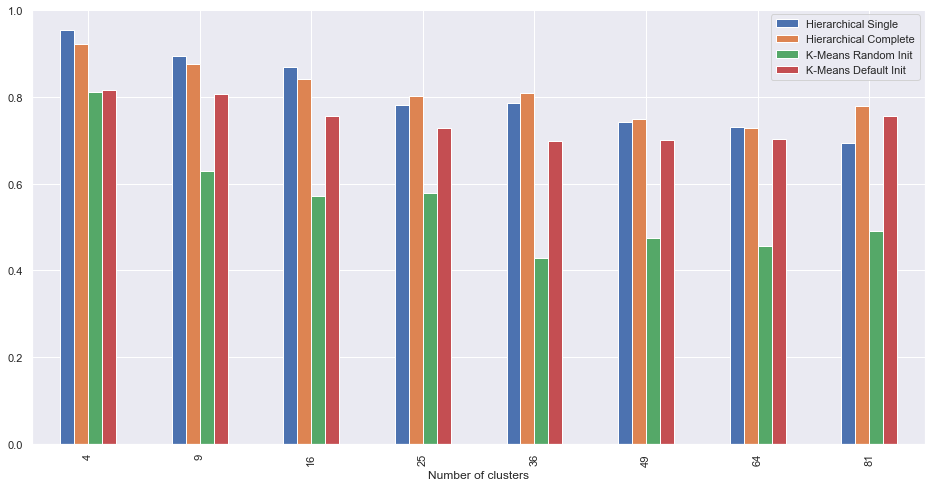

In [17]:
pd.DataFrame(results_scaled).plot.bar(x = "Number of clusters",
                                y = ["Hierarchical Single", "Hierarchical Complete", "K-Means Random Init", "K-Means Default Init"])

Novamente, o que é observado pelo gráfico de barras, é que conforme o número de clusters aumenta o desempenho nesta métrica diminui, sendo que para o K-Means utilizando a inicialização aleatória, há uma queda gritante no desempenho entre 9 e 16 clusters.

Ainda, a queda de desempenho observada no hierárquico e pro K-Means com inicialização padrão conforme o número de clusters aumenta é menor do que a observada anteriormente.

Por fim, o que se têm por esses resultados é que para um pequeno número de clusters o hierárquico aparenta ser o melhor algoritmo, independente da ligação utilizada, enquanto que para um número maior de clusters, o K-Means é uma escolher mais adequada.

- [Voltar ao topo](#Sumário)

## Visualização dos Clusters

Nesta seção é utilizada a redução de dimensionalidade usando T-SNE para visualizar os clusters encontrados. O T-SNE será executado a partir da base de dados normalizada, depois é realizada a visualização dos clusters obtidos cruzando as labels dadas pelos algoritmos executados anteriormente com a base de dados normalizada.

In [18]:
try:
    #Lembrar de apagar este arquivo se o preprocessamento mudar!
    tsne_df = pd.read_csv('tsne.csv', delimiter = ',') # Economia de operações
except:
    tsne = manifold.TSNE(n_components = 2)
    tsne_df = pd.DataFrame(tsne.fit_transform(scaled))
    tsne_df.to_csv('tsne.csv', index = False)

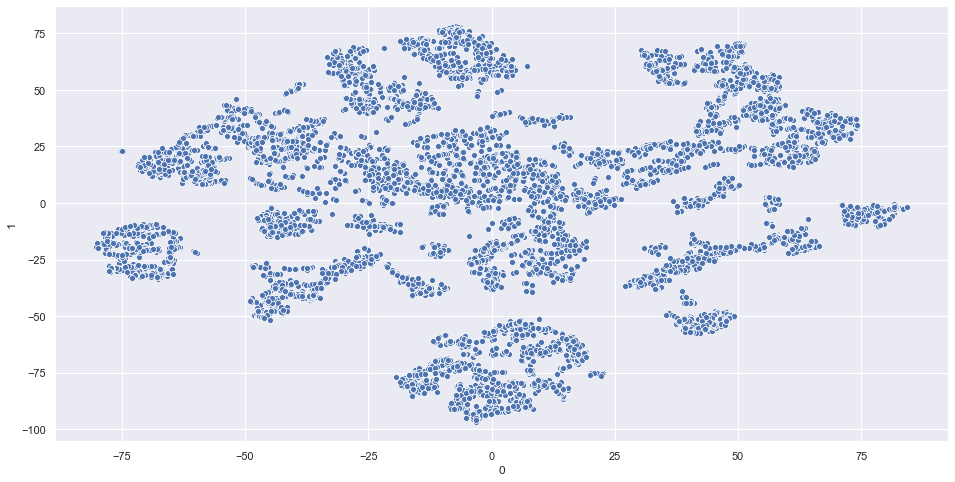

In [19]:
sns.scatterplot(x = '0', y = '1', data = tsne_df, legend = False)

O gráfico de dispersão acima, mostra dá uma ideia de como os objetos da base de dados poderiam ser agrupados, por exemplo, é possível ver na região inferior um grupo mais separado.

Inicialmente, vejamos como foi feito o agrupamento do Hierárquico Simples utilizando 4 clusters, que foi justamente o melhor resultado obtido para este algoritmo com a base de dados normalizada:

0    6995
2       2
3       1
1       1
Name: cluster_number, dtype: int64

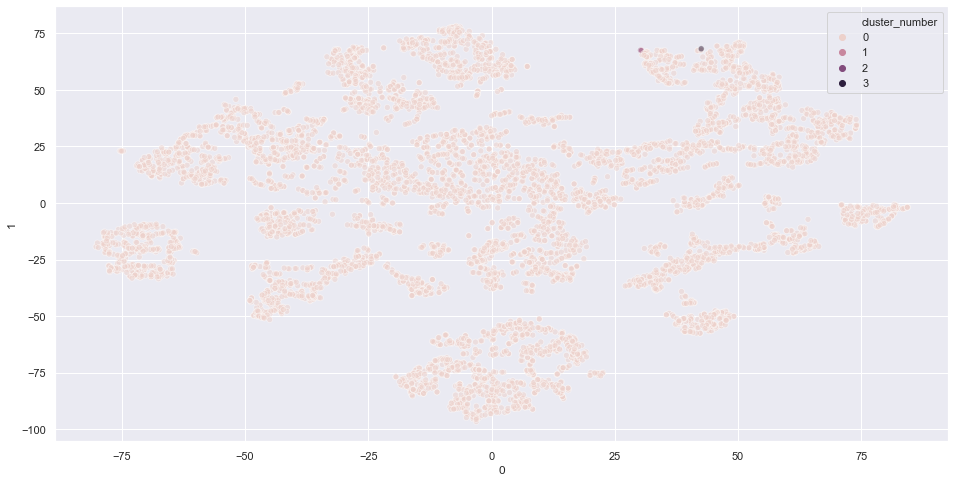

In [20]:
sns.scatterplot(x = tsne_df['0'], y = tsne_df['1'], hue = labels_hs_scaled[0]['cluster_number'], legend = 'brief', alpha = 0.5)
labels_hs_scaled[0]['cluster_number'].value_counts()

Pela visualização do gráfico acima, o que se percebe é existem três clusters com apenas um ou dois objetos, e outro contendo o resto, sendo que dois dos três clusters, se encontram sobrepostos entre si, e evidentemente todos os menores estão sobrepostos em relação ao cluster maior, mesmo assim a métrica silhueta obtida para este algoritmo foi a mais alta usando o número de clusters igual a 4. 

Aparentemente, no espaço altamente dimensional original, estes objetos se encontravam afastados dos outros, e por isso acabaram solitários em clusters separados, gerando assim um valor maior para a silhueta.

Ainda em relação ao hierárquico, vejamos como o simples se saiu com um número maior de clusters:

4     6886
0        5
6        5
2        5
13       4
      ... 
54       1
58       1
62       1
66       1
77       1
Name: cluster_number, Length: 81, dtype: int64

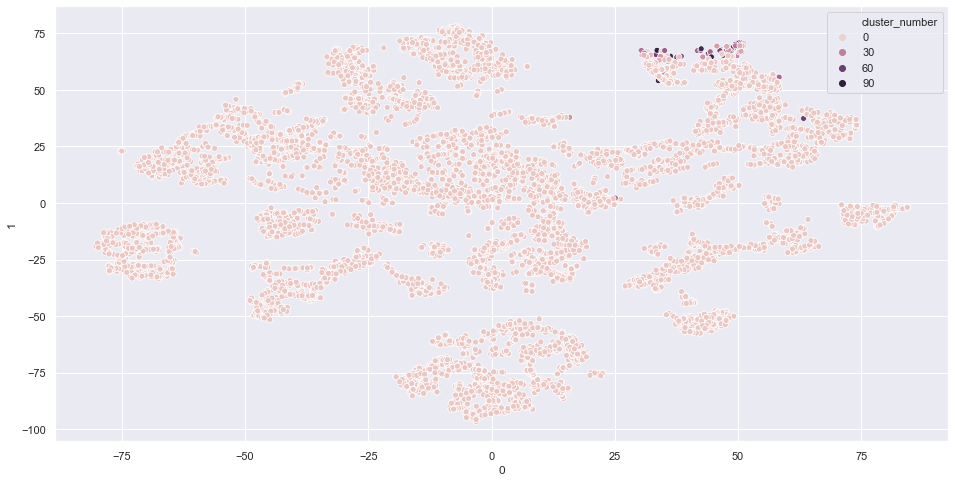

In [21]:
sns.scatterplot(x = tsne_df['0'], y = tsne_df['1'], hue = labels_hs_scaled[7]['cluster_number'], legend = 'brief')
labels_hs_scaled[7]['cluster_number'].value_counts()

Desta vez, apesar das cores utilizadas não ajudarem muito, é possível ver que os clusters gerados contém mais objetos, porém, o que se percebe é que eles estão bastante sobrepostos, fora que ainda existe casos de clusters contendo apenas um objeto, aparentemente, o que deve estar acontecendo é que há um conjunto de objetos cuja distância para o resto da base de dados é tão grande a ponto de que acabam por ficarem sozinhos ao fim da execução do algoritmo.

Antes de passarmos para o K-Means vejamos o resultado do hierárquico completo para 4 clusters:

0    6978
1      17
3       3
2       1
Name: cluster_number, dtype: int64

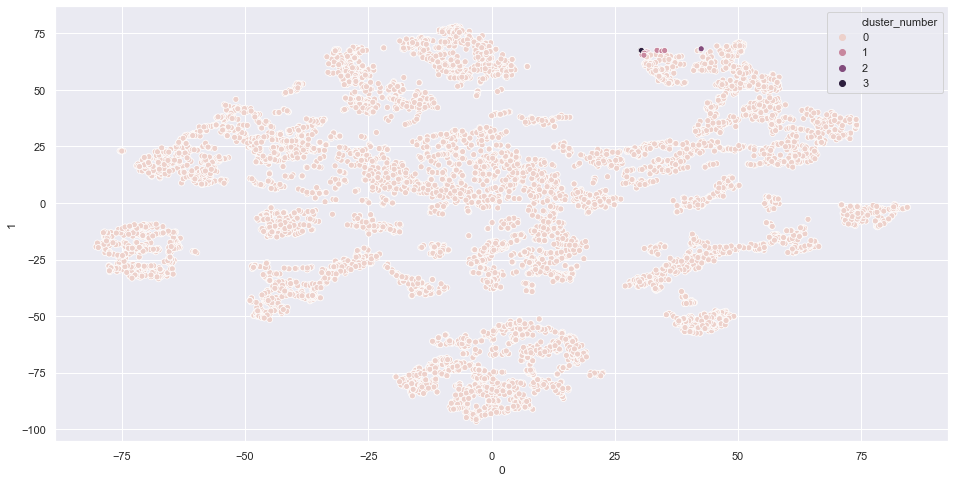

In [22]:
sns.scatterplot(x = tsne_df['0'], y = tsne_df['1'], hue = labels_hc_scaled[0]['cluster_number'], legend = 'brief')
labels_hc_scaled[0]['cluster_number'].value_counts()

Em comparação com o simples, pode-se ver que apesar de o hierárquico completo colocar um cluster contendo quase todos os objetos, houveram mais objetos agrupados nos clusters menores, porém, continua havendo um cluster de um objeto só.

Em si, imagina-se que ambos os algoritmos hierárquicos obtiveram um valor maior para silhueta pelo fato de que puseram os outliers (no espaço dimensional original) em clusters separados do resto da base de dados, sendo assim, acabaram por terem uma alta diferença intercluster.

Além disso, a visualização do T-SNE mostra que, os objetos estão distribuídos de maneira bem densa em algumas regiões, justamente aquelas na qual o maior cluster contempla.

Por fim, vejamos como o K-Means saiu, usando 4 como número de clusters, inicialmente, eis o gráfico de dispersão do K-Means com inicialização aleatória:

0    6132
3     611
2     205
1      51
Name: cluster_number, dtype: int64

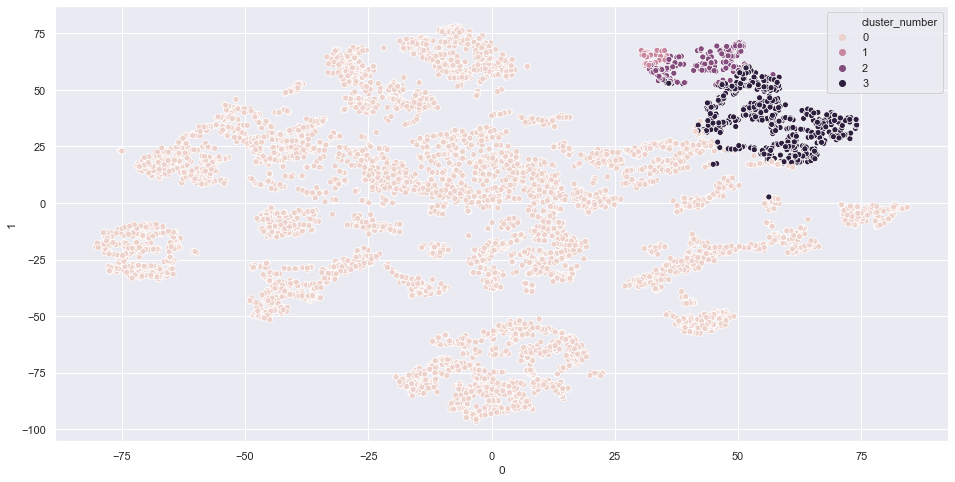

In [23]:
sns.scatterplot(x = tsne_df['0'], y = tsne_df['1'], hue = labels_kr_scaled[0]['cluster_number'], legend = 'brief')
labels_kr_scaled[0]['cluster_number'].value_counts()

Assim como nos dois casos anteriores, existe um cluster contendo a maioria esmagadora dos objetos, enquanto que os clusters menores se encontram localizados na parte positiva do eixo 0, sendo que desses, 2 se encontram bem na parte superior do eixo 1, justamente no mesmo lugar onde se encontravam os clusters que continham menos objetos obtidos pelo hierárquico. 

Contudo, ainda é possível ver que alguns objetos do cluster 2 se encontram sobrepostos com objetos do cluster 3 e 1, enquanto que o cluster 1 possui uma sobreposição com os cluster 0 e 2.

Por fim, vejamos o K-Means com a inicialização padrão:

1    6156
0     609
2     200
3      34
Name: cluster_number, dtype: int64

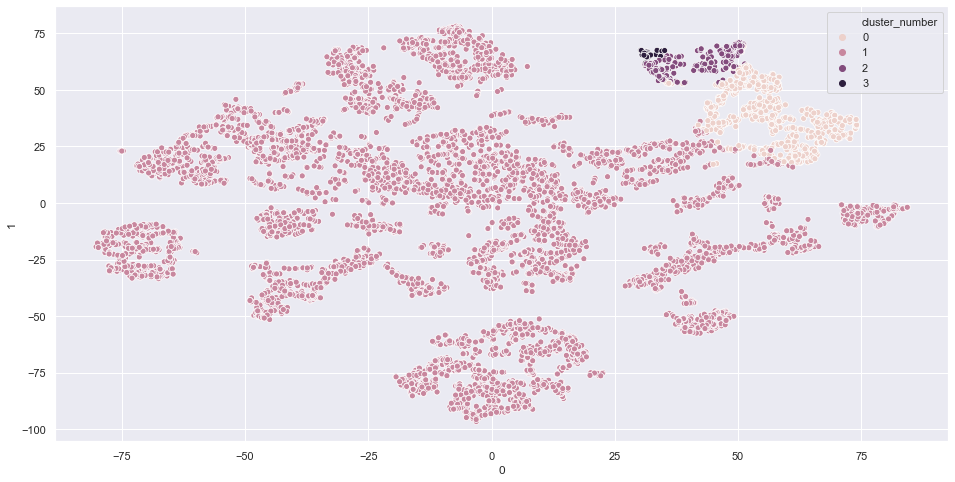

In [24]:
sns.scatterplot(x = tsne_df['0'], y = tsne_df['1'], hue = labels_kdi_scaled[0]['cluster_number'], legend = 'brief')
labels_kdi_scaled[0]['cluster_number'].value_counts()

Os resultados se assemelham a aqueles vistos com a inicialização aleatória, novamente houveram casos em que clusters se sobrepuseram parcialmente (2 e 0), enquanto outros em que a sobreposição foi praticamente total (3 e 2). O que se percebe é que, visualmente, utilizando este número de clusters, a inicialização não impacta muito nos formatos dos clusters obtidos, apesar de que o tamanho de cada cluster possuiu uma pequena diferença.

Por fim, diferentemente daquilo visto no Hierárquico, o K-Means resultou em um agrupamento diferente, não colocando N-1 objetos em um agrupamento de um objeto só e o resto em outro, sendo N o número de clusters. 

Ainda, percebe-se o motivo pelo qual o K-Means obteve um desempenho inferior na métrica silhueta: parte dos clusters estão sobrepostos, o que acaba por diminuir o valor desta métrica.

- [Voltar ao topo](#Sumário)

## Análise utilizando outras métricas
Avaliação dos agrupamentos obtidos utilizando métricas diferentes.

### Calinski-Harabasz
Esta métrica consiste na razão da soma da dispersão intra-cluster e da dispersão inter-cluster para todos os clusters (onde dispersão é definido como a soma do quadrado das distâncias).

Um valor mais alto para esta métrica indica um modelo com clusters melhores definidos.

In [25]:
results_chs_scaled = []
results_chs = []
i = 0
for num in iterations:
    results_chs_scaled.append({"Number of clusters": num, 
                    "Hierarchical Single": 
                    metrics.calinski_harabasz_score(labels_hs_scaled[i], labels_hs_scaled[i]['cluster_number']),
                    "Hierarchical Complete":
                    metrics.calinski_harabasz_score(labels_hc_scaled[i], labels_hc_scaled[i]['cluster_number']),
                    "K-Means Random Init":
                    metrics.calinski_harabasz_score(labels_kr_scaled[i], labels_kr_scaled[i]['cluster_number']),
                    "K-Means Default Init":
                    metrics.calinski_harabasz_score(labels_kdi_scaled[i], labels_kdi_scaled[i]['cluster_number'])})
    
    results_chs.append({"Number of clusters": num, 
                    "Hierarchical Single": 
                    metrics.calinski_harabasz_score(labels_hs[i], labels_hs[i]['cluster_number']),
                    "Hierarchical Complete":
                    metrics.calinski_harabasz_score(labels_hc[i], labels_hc[i]['cluster_number']),
                    "K-Means Random Init":
                    metrics.calinski_harabasz_score(labels_kr[i], labels_kr[i]['cluster_number']),
                    "K-Means Default Init":
                    metrics.calinski_harabasz_score(labels_kdi[i], labels_kdi[i]['cluster_number'])})
    i = i + 1

Text(0.5, 1.0, 'Calinski-Harabsz (Dataset Não normalizado)')

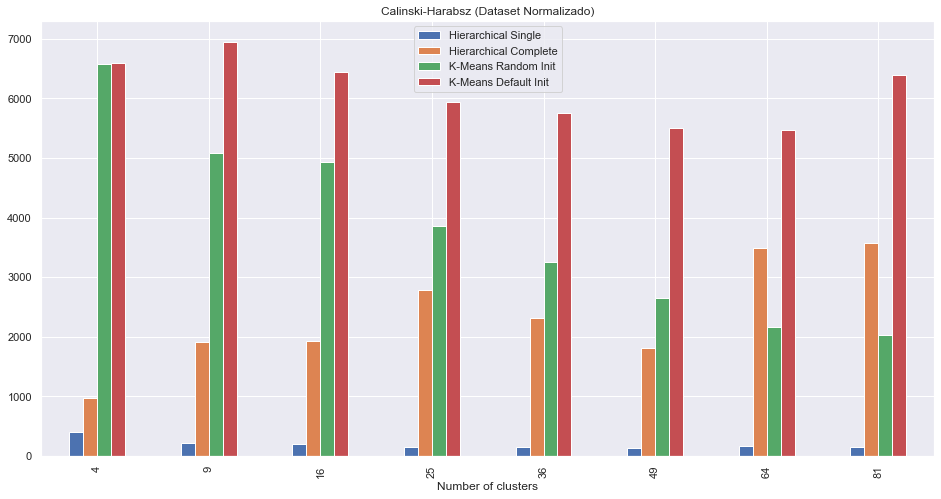

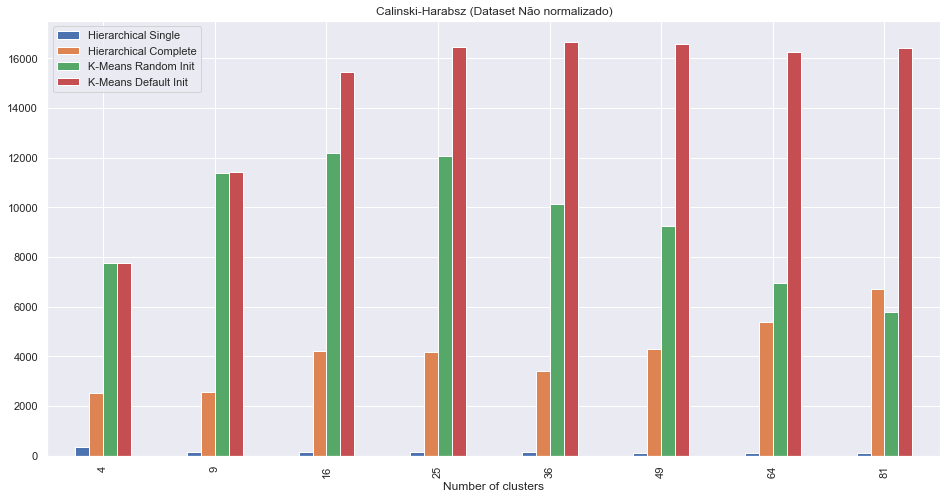

In [26]:
pd.DataFrame(results_chs_scaled).plot.bar(x = "Number of clusters",
                                y = ["Hierarchical Single", "Hierarchical Complete", "K-Means Random Init", "K-Means Default Init"])
plt.title("Calinski-Harabsz (Dataset Normalizado)")
pd.DataFrame(results_chs).plot.bar(x = "Number of clusters",
                                y = ["Hierarchical Single", "Hierarchical Complete", "K-Means Random Init", "K-Means Default Init"])
plt.title("Calinski-Harabsz (Dataset Não normalizado)")

Pela análise dos dois gráficos, percebe-se que por esta métrica, obtem-se claramente resultados superiores para o algoritmo do K-Means, sendo que a inicialização aleatória possui um desempenho inferior em relação a outra inicialização.

Ainda, o que se percebe é um valor baixíssimo para o hierárquico com ligação simples.

Por fim, para esta métrica o que se tem são valores bastante distintos (de maneira proporcional) em relação a silhueta, uma vez que na silhueta o que se viu foram os algoritmos além de terem valores inferiores conforme o número de clusters aumenta, o hierárquico se mostrou superior ao K-Means até então.

### Davies-Bouldin
Esta métrica signifca a similiaridade média entre clusters, onde a similiaridade é a medida que compara a distância entre clusters com o tamanho dos próprios clusters.

0 é o menor valor possível para esta métrica, sendo que valores próximos disso indicam um particionamento melhor.

Em relação a este experimento, é interessante usar esta métrica, uma vez que obteve-se clusters com um número muito baixo de objetos, principalmente no hierárquico.

In [27]:
results_db_scaled = []
results_db = []
i = 0
for num in iterations:
    results_db_scaled.append({"Number of clusters": num, 
                    "Hierarchical Single": 
                    metrics.davies_bouldin_score(labels_hs_scaled[i], labels_hs_scaled[i]['cluster_number']),
                    "Hierarchical Complete":
                    metrics.davies_bouldin_score(labels_hc_scaled[i], labels_hc_scaled[i]['cluster_number']),
                    "K-Means Random Init":
                    metrics.davies_bouldin_score(labels_kr_scaled[i], labels_kr_scaled[i]['cluster_number']),
                    "K-Means Default Init":
                    metrics.davies_bouldin_score(labels_kdi_scaled[i], labels_kdi_scaled[i]['cluster_number'])})
    
    results_db.append({"Number of clusters": num, 
                    "Hierarchical Single": 
                    metrics.davies_bouldin_score(labels_hs[i], labels_hs[i]['cluster_number']),
                    "Hierarchical Complete":
                    metrics.davies_bouldin_score(labels_hc[i], labels_hc[i]['cluster_number']),
                    "K-Means Random Init":
                    metrics.davies_bouldin_score(labels_kr[i], labels_kr[i]['cluster_number']),
                    "K-Means Default Init":
                    metrics.davies_bouldin_score(labels_kdi[i], labels_kdi[i]['cluster_number'])})
    i = i + 1

Text(0.5, 1.0, 'Davies-Bouldin (Dataset Não normalizado)')

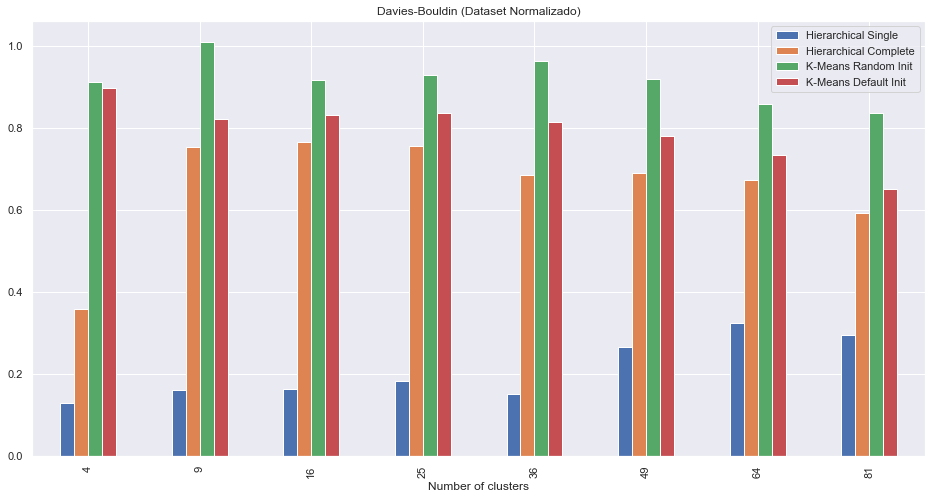

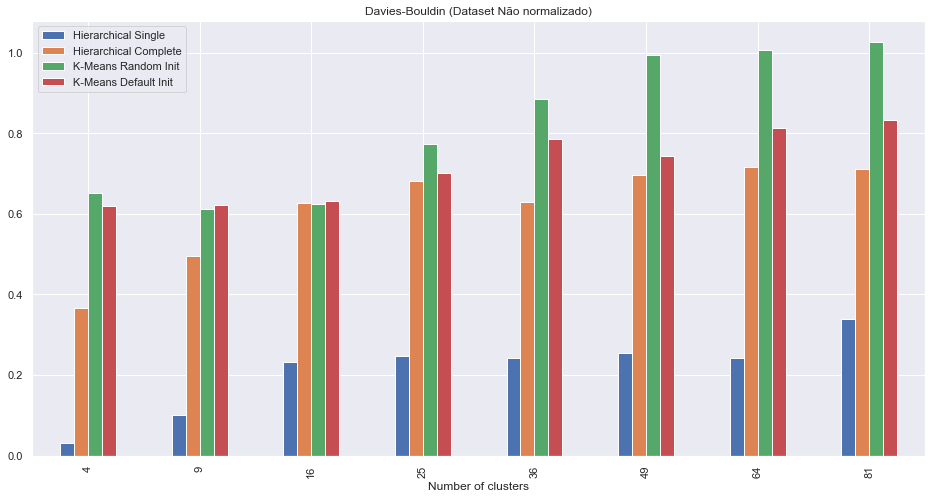

In [28]:
pd.DataFrame(results_db_scaled).plot.bar(x = "Number of clusters",
                                y = ["Hierarchical Single", "Hierarchical Complete", "K-Means Random Init", "K-Means Default Init"])
plt.title("Davies-Bouldin (Dataset Normalizado)")
pd.DataFrame(results_db).plot.bar(x = "Number of clusters",
                                y = ["Hierarchical Single", "Hierarchical Complete", "K-Means Random Init", "K-Means Default Init"])
plt.title("Davies-Bouldin (Dataset Não normalizado)")

Por esta métrica, o que se vê nos gráficos, são resultados melhores para o hierárquico, sendo que o com ligação simples o melhor.

Ainda, tem-se que, os resultados para esta métrica pioram conforme o número de clusters aumenta, no caso da base de dados não normalizada, enquanto que para a base de dados normalizada o desempenho do K-Means melhorou conforme o número de clusters aumenta.

- [Voltar ao topo](#Sumário)

## Conclusão

Escolher o melhor algoritmo dependerá muito do critério a ser utilizado, se visto apenas pela silhueta, poderiamos concluir que o hierarquico é superior ao K-Means para esta base de dados, enquanto pelo Calinski-Harabasz, o K-Means se mostrou um algoritmo melhor.

Enquanto que, se observado visualmente, percebe-se que o hierárquico tratou de gerar clusters com apenas um ou poucos objetos, e colocando a maioria esmagadora em outro, o que acaba por dar um valor maior a silhueta, uma vez que os objetos pertencentes aos clusters menores estão mais afastados do cluster maior. 

Do lado do K-Means, independente da inicialização utilizada, o que se observou é que os clusters foram gerados sem colocar um objeto sozinho em um cluster qualquer, contudo, para um valor baixo de clusters, conforme visualizado anteriormente, a sobreposição destes é evidente, o que leva a um valor menor da métrica silhueta.

Em relação ao tipo de inicialização utilizado, percebe-se que optar por uma inicialização aleatória, pode vir a comprometer o desempenho obtido pelo algoritmo em relação a silhueta, o que é de se imaginar, uma vez que o tipo de cluster obtido irá depender da sorte, ou melhor do que foi selecionado inicialmente como centróide.

Sendo assim, o melhor algoritmo pelas observações feitas anteriormente é o K-Means utilizando a inicialização padrão para um número de clusters igual a 4, pois apesar de que apresentou um valor levemente inferior na silhueta em relação ao Hierárquico, também apresentou um valor bastante superior a este no Calinski-Harabasz, e ainda, ao visualizar o resultado obtido em duas dimensões, o que se viu foi que apesar de possuir alguma sobreposição entre clusters, cada cluster não se limita a um único objeto, sendo assim pode ser mais interessante de ser utilizado por um especialista no caso da análise do conteúdo dos mesmos.